# A simplified version of 'interpolate_the_gap_NA' which just generates the synthetic swot data from the NA simulation without all of the plots

In [1]:
import JWS_SWOT_toolbox as swot
import pickle 
from datetime import datetime, timedelta
import numpy as np
%load_ext autoreload
%autoreload 2

## 1. Import SWOT data and files first for a pass so we can get the noise profiles

In [2]:
# Read in the SWOT data for this pass
pass_num = 242
lat_max = 30
lat_min = 28

data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/'
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/SCIENCE/'

_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_num)

sample_index = 2 
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_length, track_length_nadir]
karin, nadir = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# Generate coordinates
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

Error processing file /expanse/lustre/projects/cit197/jskinner1/SWOT/SCIENCE/SWOT_L2_LR_SSH_Basic_007_242_20231202T004300_20231202T013345_PIC0_01.nc, cycle 7: time values outside range of 64 bit signed integers


/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/import_and_process.py:212: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.09923142228240318
File indices with outlier variance: [22]
High variance cycle numbers: {23}
----------------------------------
Total Number of Good KaRIn strips : 52
Number of Quality Masked KaRIn strips : 12
Number of High Variance strips removed : 2

Number of good nadir cycles: 27
Number of bad nadir cycles: 1
X grid range (km): 0.00 to 156.51 (span: 156.51 km)
Y grid range (km): 0.00 to 242.36 (span: 242.36 km)
Track Length: 242.36 km
Swath Width: 78.26 km
Karin spacing: dx = 1.99 km, dy = 2.01 km
Nadir spacing: dy = 7.09 km
Computing KaRIn spectra...
Computing Nadir spectra...


In [3]:
print(karin.lat.shape)
print(karin.lat_full.shape)

(28, 113, 60)
(113, 69)


In [4]:
#  Match the simulation dates with the SWOT dates
NA_folder = "/expanse/lustre/projects/cit197/jskinner1/NA_daily_snapshots"

# 1) choose sim dates for KaRIn times
_, _, matched_dates = swot.pick_range_from_karin_times(
    karin_time_dt=karin.time_dt,
    data_folder=NA_folder,
    mode="cyclic"    # or 'absolute' if sim year == SWOT year
)

#2) interpolate each sim day onto the ONE constant KaRIn grid
NA_karin_full_ssh, NA_karin_ssh, NA_nadir_ssh, used_dates = swot.load_sim_on_karin_nadir_grids(
    karin, 
    nadir, 
    data_folder=NA_folder, 
    matched_dates=matched_dates 
)

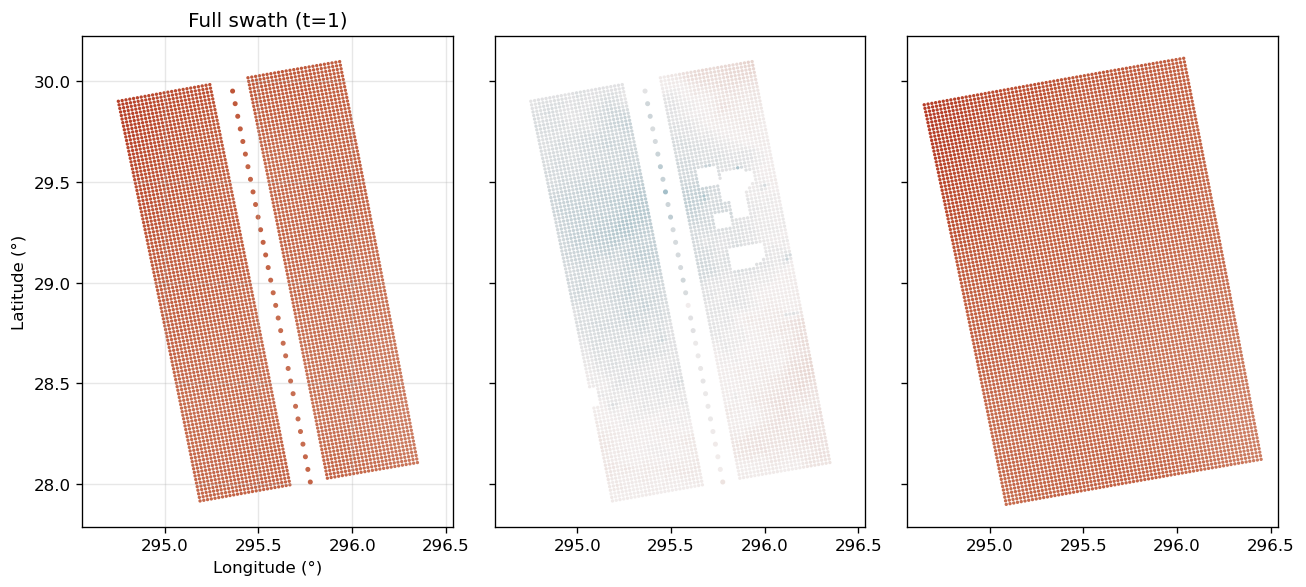

In [5]:
import numpy as np
import matplotlib.pyplot as plt

t = 1  # time index

# --- finite masks ---
mk = np.isfinite(NA_karin_ssh[t]) & np.isfinite(karin.lat[t]) & np.isfinite(karin.lon[t])
mn = np.isfinite(NA_nadir_ssh[t]) & np.isfinite(nadir.lat[t]) & np.isfinite(nadir.lon[t])

# --- plot ---
fig, axs = plt.subplots(1, 3, figsize=(11, 5), dpi=120, sharex=True, sharey=True)

vmin = -1.0 
vmax = 1.0

# Panel 1: full
sc1 = axs[0].scatter(nadir.lon[t], nadir.lat[t], c=NA_nadir_ssh[t], s=4,
                     cmap="cmo.balance", vmin = vmin, vmax = vmax)
sc1 = axs[0].scatter(karin.lon[t], karin.lat[t], c=NA_karin_ssh[t], s=1,
                     cmap="cmo.balance", vmin = vmin, vmax = vmax)
axs[0].set_title(f"Full swath (t={t})")
axs[0].set_xlabel("Longitude (°)")
axs[0].set_ylabel("Latitude (°)")
axs[0].grid(True, alpha=0.3)

sc1 = axs[1].scatter(nadir.lon[t], nadir.lat[t], c=nadir.ssha[t], s=4,
                     cmap="cmo.balance", vmin = vmin, vmax = vmax)
sc1 = axs[1].scatter(karin.lon[t], karin.lat[t], c=karin.ssha[t], s=1,
                     cmap="cmo.balance", vmin = vmin, vmax = vmax)

sc2 = axs[2].scatter(karin.lon_full, karin.lat_full, c=NA_karin_full_ssh[t], s=1,
                     cmap="cmo.balance", vmin = vmin, vmax = vmax)

plt.tight_layout()
plt.show()

## 2. Now import and process the NA simulation data for same pass and location

In [6]:
# Now the data is processed we can init all out data classes with NA_Karin/Nadir
ncycles = NA_karin_ssh.shape[0]
track_length_karin =  NA_karin_ssh.shape[1]
track_length_nadir = NA_nadir_ssh.shape[1]
dims_NA = [ncycles, track_length_karin, track_length_nadir]

karin_NA, nadir_NA = swot.init_swot_arrays(dims_NA, lat_min, lat_max, pass_num) # init a class for the karin/nadir parts of the data
karin_NA.ssh_orig = NA_karin_full_ssh # save the original ssh
karin_NA.ssh = NA_karin_ssh
karin_NA.ssha = NA_karin_ssh - np.nanmean(NA_karin_ssh, axis=(1, 2), keepdims=True)
karin_NA.lat = karin.lat
karin_NA.lon = karin.lon
karin_NA.date_list=matched_dates  

nadir_NA.ssh = NA_nadir_ssh
nadir_NA.ssha = NA_nadir_ssh - np.nanmean(NA_nadir_ssh, axis=(1), keepdims=True)
nadir_NA.lat = nadir.lat
nadir_NA.lon = nadir.lon

# Builds the coordinate grids -- in [m]
karin_NA.coordinates()
nadir_NA.coordinates()

# Compute spectra
karin_NA.compute_spectra()
nadir_NA.compute_spectra()

X grid range (km): 0.00 to 156.51 (span: 156.51 km)
Y grid range (km): 0.00 to 242.36 (span: 242.36 km)
Track Length: 242.36 km
Swath Width: 78.26 km
Karin spacing: dx = 1.99 km, dy = 2.01 km
Nadir spacing: dy = 7.09 km
Computing KaRIn spectra...
Computing Nadir spectra...


#### Plot the NA sim and SWOT data on the same plot for comparison

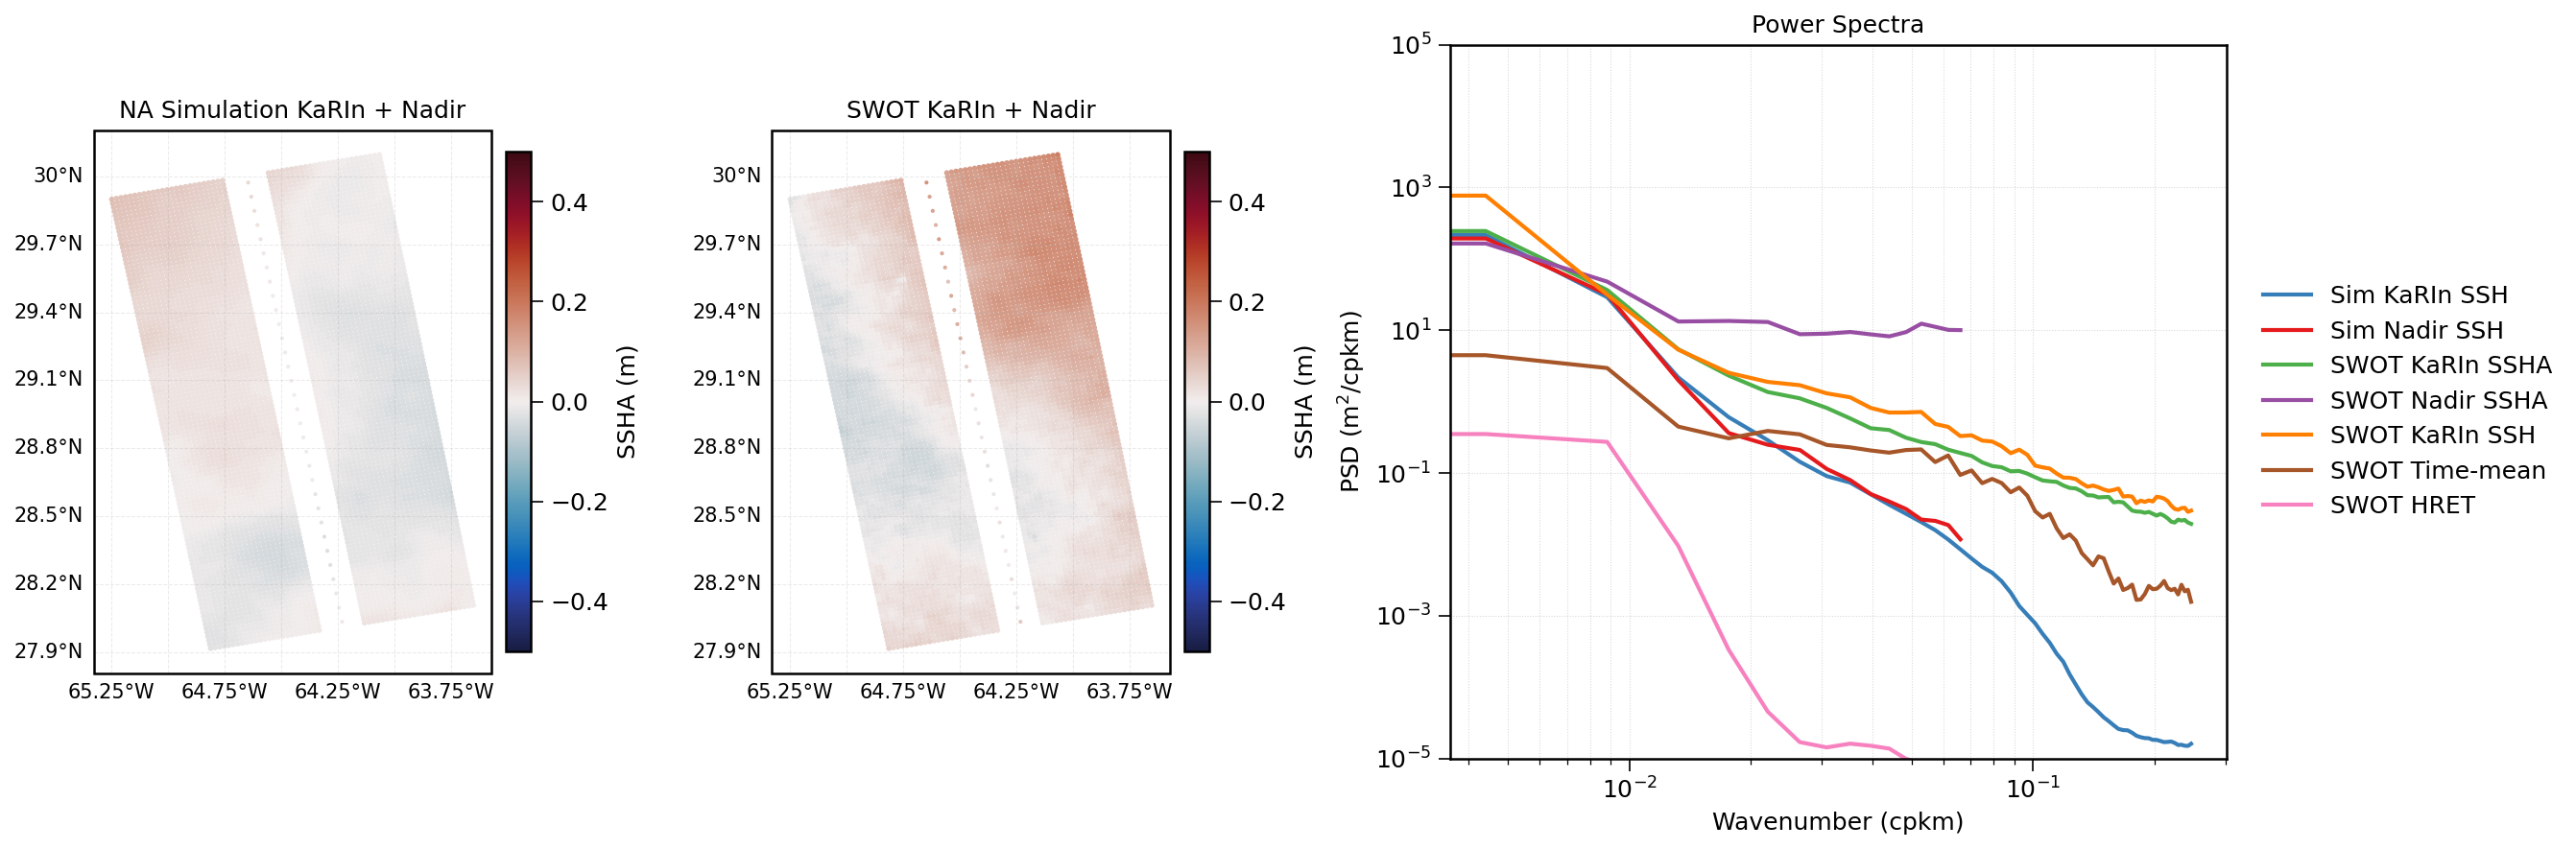

In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cmocean

swot.set_plot_style()

index = 2
vmin, vmax = -0.5, 0.5
ylims = (1e-5, 1e5)
cmap = cmocean.cm.balance

fig = plt.figure(figsize=(18, 6), dpi=150)
gs = GridSpec(1, 3, width_ratios=[1, 1, 1.6], figure=fig)

# ───── Simulation Map ─────
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
sc0 = ax0.scatter(
    karin.lon[index].flatten(), karin.lat[index].flatten(),
    c=karin_NA.ssha[index].flatten(), s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax0.scatter(
    nadir.lon[index], nadir.lat[index], c=nadir_NA.ssha[index], vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree()
)
ax0.coastlines()
ax0.set_title("NA Simulation KaRIn + Nadir")
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl0.top_labels = gl0.right_labels = False
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.7, pad=0.03)
cbar0.set_label("SSHA (m)")

# ───── SWOT Map ─────
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
sc1 = ax1.scatter(
    karin.lon[index], karin.lat[index],
    c=karin.ssha[index], s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax1.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=1, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o'
)
ax1.coastlines()
ax1.set_title(f'SWOT KaRIn + Nadir')
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl1.top_labels = gl1.right_labels = False
cbar1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.7, pad=0.03)
cbar1.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax2 = fig.add_subplot(gs[0, 2])
ax2.loglog(karin_NA.wavenumbers_cpkm, karin_NA.spec_alongtrack_av, label='Sim KaRIn SSH', linewidth=2)
ax2.loglog(nadir_NA.wavenumbers_cpkm, nadir_NA.spec_alongtrack_av, label='Sim Nadir SSH', linewidth=2)
#ax2.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_ssh, label='Sim KaRIn SSH', linewidth=1.5)

ax2.loglog(karin.wavenumbers_cpkm, karin.spec_alongtrack_av, label='SWOT KaRIn SSHA', linewidth=2)
ax2.loglog(nadir.wavenumbers_cpkm, nadir.spec_alongtrack_av, label='SWOT Nadir SSHA', linewidth=2)
ax2.loglog(karin.wavenumbers_cpkm, karin.spec_ssh, label='SWOT KaRIn SSH', linewidth=2.0)
ax2.loglog(karin.wavenumbers_cpkm, karin.spec_tmean, label='SWOT Time-mean', linewidth=2.0)
#ax2.loglog(karin.wavenumbers * 1e3, karin.spec_filt_tmean, label='SWOT Filtered', linewidth=1.2)
ax2.loglog(karin.wavenumbers_cpkm, karin.spec_tide, label='SWOT HRET', linewidth=2.0)

ax2.set_xlabel("Wavenumber (cpkm)")
ax2.set_ylabel("PSD (m$^2$/cpkm)")
ax2.set_ylim(ylims)
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2.set_title("Power Spectra")

plt.tight_layout()
plt.show()


## 3. Estimate the balanced and unbalanced components of the SWOT data


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.9183e+02 ± 1.68e+01
lambda balanced :   1.6822e+05 ± 5.54e+03
slope balanced  :   5.2607e+00 ± 2.20e-01
Amp. noise      :   3.7916e+00 ± 3.19e-01
lambda noise    :   1.0001e+05 ± 0.00e+00
slope noise     :   1.5061e+00 ± 3.71e-02

---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 10.056365352260649 ± 1.02e+00


(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (m$^2$ cpm$^{-1}$)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (m$^2$ cpm$^{-1}$)'>],
       dtype=object))

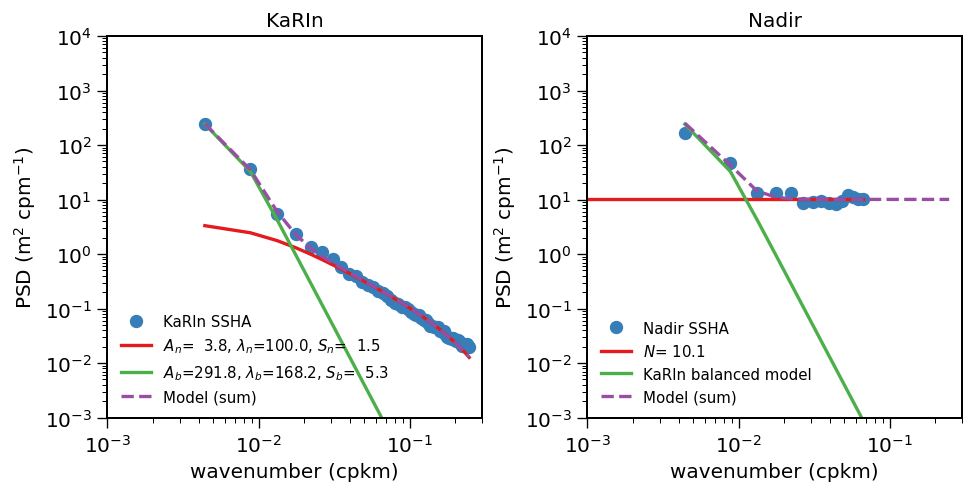

In [8]:
# KaRIn model fit
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, poptcwg_karin, poptcwg_nadir)

## 4. Generate Covariances for the SWOT data signal and noise

We now generate covariance functions for our spectrum models of the SWOT data to synthesize the noise component of the SWOT spectrum. We wont extend the target grid at the stage, we will keep it at 60. 


In [10]:
# ───── Generate Synthetic Fields from the SWOT Models ─────
# --- Extract Parameters from SWOT data fit ---
A_b, lam_b, s_b = poptcwg_karin[0], poptcwg_karin[1], poptcwg_karin[2]
A_n, s_n, lam_n = poptcwg_karin[3], poptcwg_karin[5], 1e5  # lam_n fixed at 100 km
N_n = poptcwg_nadir[0]

# --- Grid and Spacing ---
nx, ny = 2 * karin.swath_width, karin.track_length
nn = nadir.track_length
dx, dy, dn = karin.dx, karin.dy, nadir.dy

# --- Covariance Functions ---
S_bal = lambda k: A_b / (1 + (lam_b * k)**s_b)
sigma_taper = 2 * np.pi * 1e3 / np.sqrt(2 * np.log(2))
S_unb = lambda k: A_n / (1 + (lam_n * k)**2)**(s_n/2) * np.exp(-0.5 * (sigma_taper**2) * k**2)
sigma_noise = np.sqrt(N_n / (2 * dn))

c_bal = swot.cov(S_bal, 5000000, 10000e3)
c_unb = swot.cov(S_unb, 5000, 10000e3)

# --- Observation Points ---
xk, yk = karin.x_obs_grid.flatten(), karin.y_obs_grid.flatten()
xn, yn = nadir.x_grid.flatten(), nadir.y_grid.flatten()
xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# --- Covariance and Noise Matrices ---
C = swot.build_covariance_matrix(c_bal, xobs, yobs)
N, Nk = swot.build_noise_matrix(c_unb, xk, yk, sigma_noise, nn, nx*ny)

# --- Cholesky Decomposition ---
F = swot.cholesky_decomp(C, "C")
Fk = swot.cholesky_decomp(Nk, "Nk")

# --- Generate Synthetic SWOT Signal+ Noise ---
h, eta, eta_k, eta_n = swot.generate_signal_and_noise(F, Fk, sigma_noise, nx*ny, nn)

# --- Target (Reconstruction) Grid ---
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin, extend=False)

# --- Estimate Signal on Target Grid ---
ht = swot.estimate_signal_on_target(c_bal, xt, yt, xobs, yobs, C, N, h + eta)

Variance from spectrum:   0.001842
Variance from covariance: 0.001842
Variance from spectrum:   0.000080
Variance from covariance: 0.000080
Calculating covariance matrices...
Calculating noise matrices...
Performing Cholesky decomposition for C...
Cholesky(C) time: 1.8904 seconds
Performing Cholesky decomposition for Nk...
Cholesky(Nk) time: 1.8287 seconds
Estimating signal on target points...
Signal estimation time: 8.8380 seconds


/scratch/jskinner1/job_42268881/ipykernel_1778284/4022942745.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


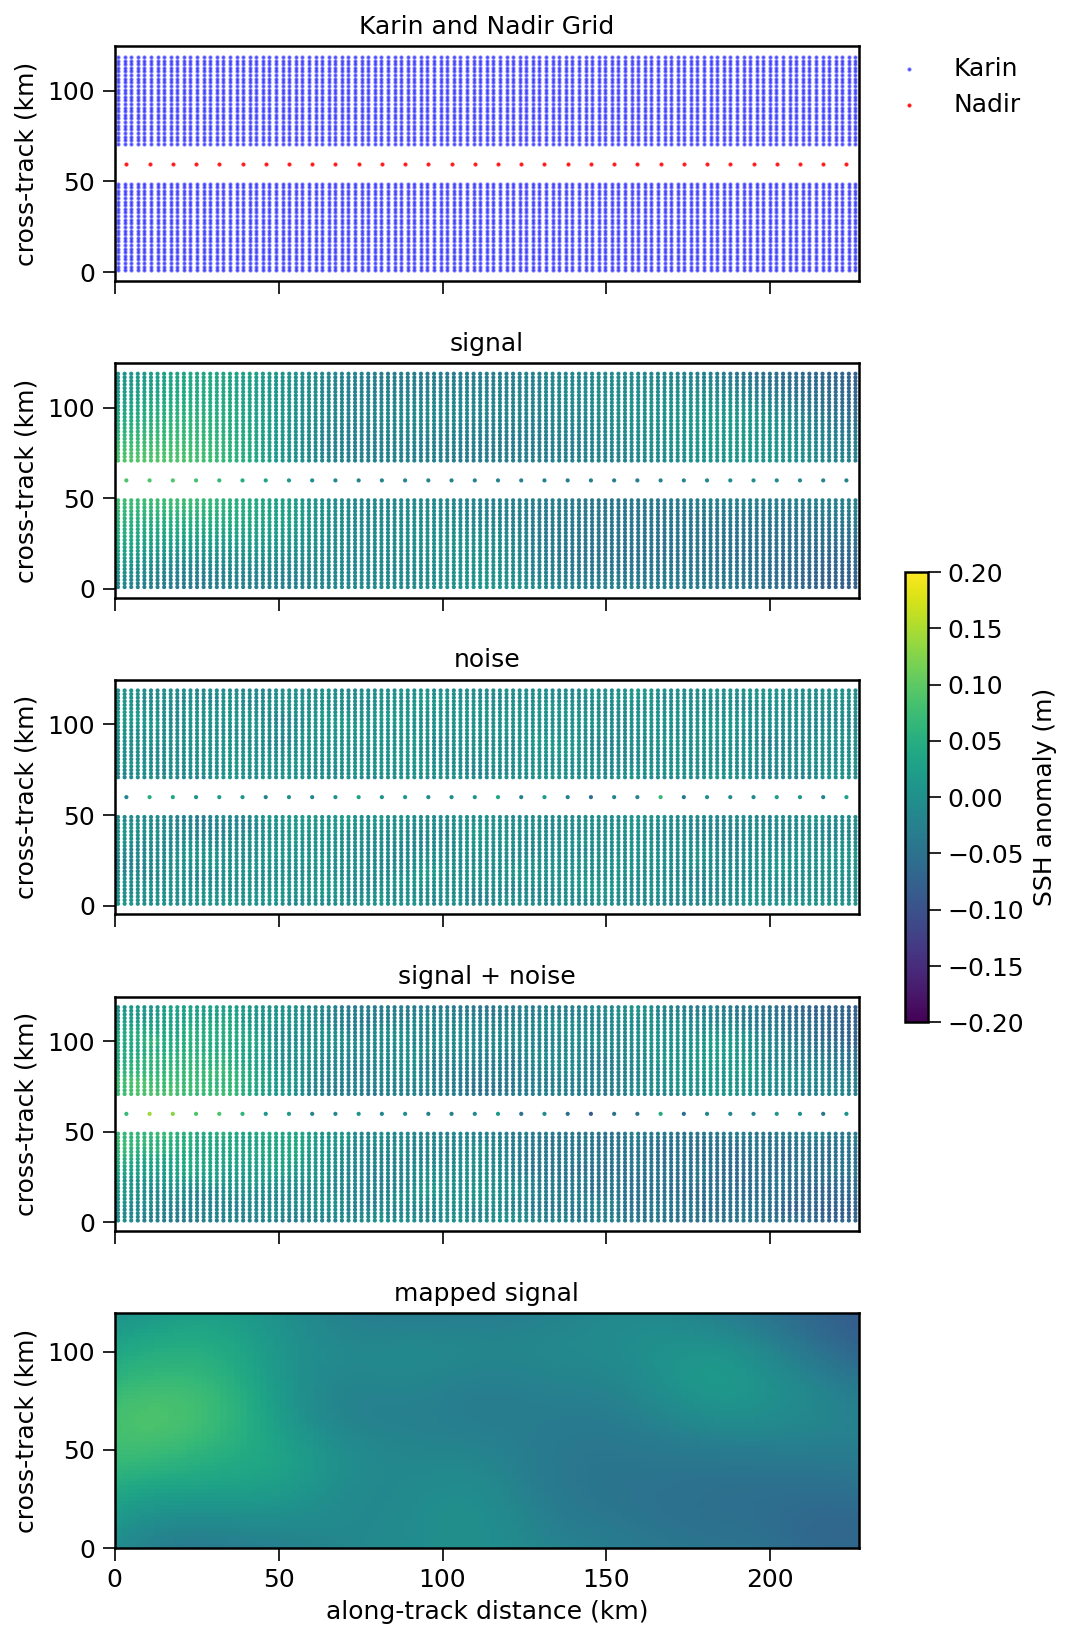

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

In [11]:
# Check the generation 
fig, axes = plt.subplots(
    5, 1, figsize=(8, 13), sharex=True,
    gridspec_kw={'hspace': 0.35}
)

vmin = -0.2 
vmax = 0.2

axes[0].scatter(yk * 1e-3, xk * 1e-3, s=1,  c='blue', label='Karin', alpha=0.5)
axes[0].scatter(yn * 1e-3, xn * 1e-3, s=1, c='red',  label='Nadir', alpha=0.8)
axes[0].set_title('Karin and Nadir Grid')
axes[0].set_ylabel('cross-track (km)')
axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

axes[1].scatter(1e-3 * yobs, 1e-3 * xobs, c = h,  s=1, vmin=vmin, vmax=vmax)
axes[1].set_title('signal')
axes[1].set_ylabel('cross-track (km)')

axes[2].scatter(1e-3 * yobs, 1e-3 * xobs, c = eta, s=1, vmin=vmin, vmax=vmax)
axes[2].set_title('noise')
axes[2].set_ylabel('cross-track (km)')

axes[3].scatter(1e-3 * yobs, 1e-3 * xobs, c = h + eta, s=1, vmin=vmin, vmax=vmax)
axes[3].set_title('signal + noise')
axes[3].set_ylabel('cross-track (km)')

im = axes[4].imshow(
    ht.reshape((nyt, nxt)).T, origin='lower',
    extent=np.array([0, nyt * karin.dy, 0, nxt * karin.dx]) * 1e-3,
    vmin=vmin, vmax=vmax, aspect='auto'
)
axes[4].set_title('mapped signal')
axes[4].set_xlabel('along-track distance (km)')
axes[4].set_ylabel('cross-track (km)')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, pad=0.05)
cbar.set_label('SSH anomaly (m)')

plt.tight_layout()
plt.show()
plt.gcf()

### Generate synthetic obervations from covariance functions and reconstruct the spectrum of original field

In [12]:
# generates n synthetic realisations of the signal and noise
n_realizations = karin_NA.ssha.shape[0]
hs, etas, etas_k, etas_n = swot.generate_synthetic_realizations(swot, F, Fk, sigma_noise, nx, ny, nn, n_realizations)

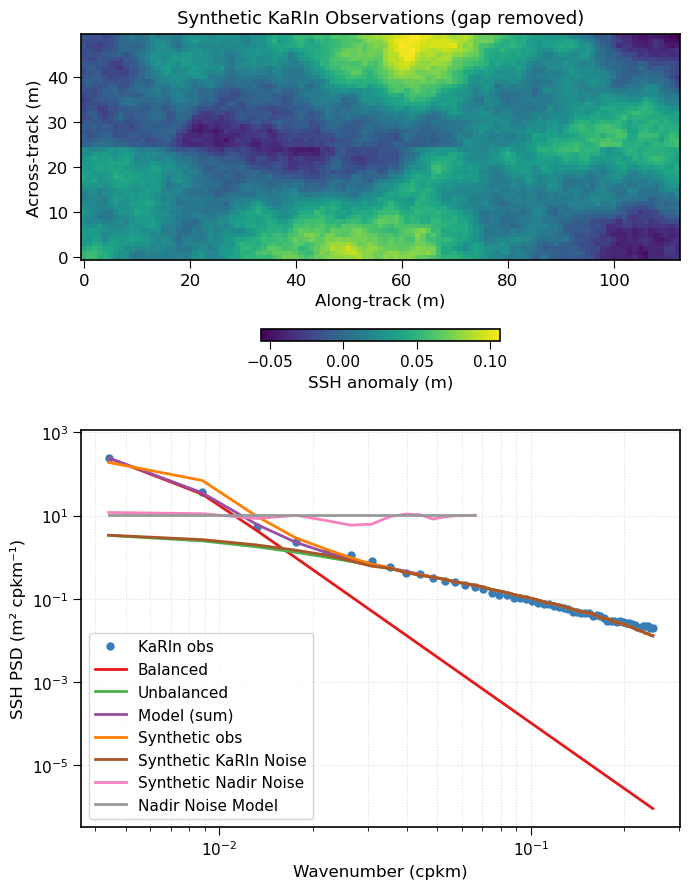

In [13]:
# Plot the mean of the synthetic realisations
import xarray as xr

# karin component
h_k = hs[:, :nx*ny]  # karin signal  
h_combined = h_k  + etas_k.reshape(etas_k.shape[0], -1) # karin signal + noise

# Get the one-sided spectra
k_karin = karin.wavenumbers[int(karin.track_length/2):]  # units [1/m]
karin_spec_sample_mean = karin.spec_alongtrack_av[int(karin.track_length/2):]
k_nadir = nadir.wavenumbers[int(nadir.track_length/2):]  # units [1/m]
nadir_spec_sample_mean = nadir.spec_alongtrack_av[int(nadir.track_length/2):]

# Put the wavenumbers through the models to get the functional form
spbalanced = swot.balanced_model(k_karin[1:], *poptcwg_karin[0:3])
spunbalanced = swot.unbalanced_model(k_karin, *poptcwg_karin[3:7])
spnoise_nadir = swot.nadir_noise_model(k_nadir, poptcwg_nadir[0])

# h_syn is the combined reshaped into (time, nx, ny)
h_syn = np.zeros((hs.shape[0], ny, nx))
for i in range(hs.shape[0]):
    h_syn[i, :, :] = h_combined[i, :].reshape(ny, nx)

# ---- Spectra ----
h_syn_coords = { 
    'sample': np.arange(h_syn.shape[0]),
    'pixel':  np.arange(h_syn.shape[2])*karin_NA.dx,   # along-track
    'line':  np.arange(h_syn.shape[1])*karin_NA.dy   # cross-track
}

h_syn_xr = xr.DataArray(h_syn, coords = h_syn_coords, dims = ['sample', 'line', 'pixel'])
spec_h_syn = swot.mean_power_spectrum(h_syn_xr, karin.window, 'line', ['sample', 'pixel'])
spec_h_syn = spec_h_syn[int(karin.track_length/2):]

eta_k_xr = xr.DataArray(etas_k, coords = h_syn_coords, dims = ['sample', 'line', 'pixel'])
eta_k_syn = swot.mean_power_spectrum(eta_k_xr, karin.window, 'line', ['sample', 'pixel'])
spec_eta_k = eta_k_syn[int(karin.track_length/2):]

# compute the nadir spectrum
eta_nt_coords = {
    'sample': np.arange(etas_n.shape[0]),
    'nadir_line': np.arange(0.5, etas_n.shape[1], 1.0) * nadir.dy
}

eta_n_xr = xr.DataArray(etas_n, coords = eta_nt_coords, dims = ['sample', 'nadir_line'])
spec_eta_n = swot.mean_power_spectrum(eta_n_xr, nadir.window, 'nadir_line', ['sample'])
spec_eta_n = spec_eta_n[int(nadir.track_length/2):]

# ---- PLOT ----
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 9), dpi=100, gridspec_kw={'height_ratios': [0.7, 0.8]})

sc = ax1.imshow(h_syn[0, :, :].T, aspect='auto', origin='lower')
ax1.set_title('Synthetic KaRIn Observations (gap removed)', fontsize=13, pad=8)
ax1.set_ylabel('Across‐track (m)', fontsize=12)
ax1.set_xlabel('Along‐track (m)', fontsize=12)
cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', shrink=0.4, pad=0.2)
cbar.ax.tick_params(labelsize=11)
cbar.set_label('SSH anomaly (m)', fontsize=12)

# ax2.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, label='Sim KaRIn SSH', linewidth=2)
ax2.loglog(k_karin * 1e3, karin_spec_sample_mean, 'o', markersize=5, label='KaRIn obs') # from above
ax2.loglog(k_karin[1:] * 1e3, spbalanced, lw=2, label='Balanced') # from above model
ax2.loglog(k_karin[1:] * 1e3, spunbalanced[1:], lw=2, label='Unbalanced') # from above model
ax2.loglog(k_karin[1:] * 1e3, (spunbalanced[1:] + spbalanced), '-', lw=2, label='Model (sum)') # from above model
ax2.loglog(k_karin[1:] * 1e3, spec_h_syn[1:], '-', lw=2, label='Synthetic obs')
ax2.loglog(k_karin[1:] * 1e3, spec_eta_k[1:], lw=2, label='Synthetic KaRIn Noise')
ax2.loglog(k_nadir[1:] * 1e3, spec_eta_n[1:], lw=2, label='Synthetic Nadir Noise')
plt.loglog(k_nadir[1:] * 1e3, spnoise_nadir[1:], label = r'Nadir Noise Model')

ax2.set_xlabel('Wavenumber (cpkm)', fontsize=12)
ax2.set_ylabel('SSH PSD (m² cpkm⁻¹)', fontsize=12)
ax2.legend(loc='lower left', fontsize=11, frameon=True)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.grid(True, which='both', linestyle=':', alpha=0.4)

plt.tight_layout(h_pad=2)
plt.show()

#### Use noise models to generate synthetic SWOT observations from the NA simulation data

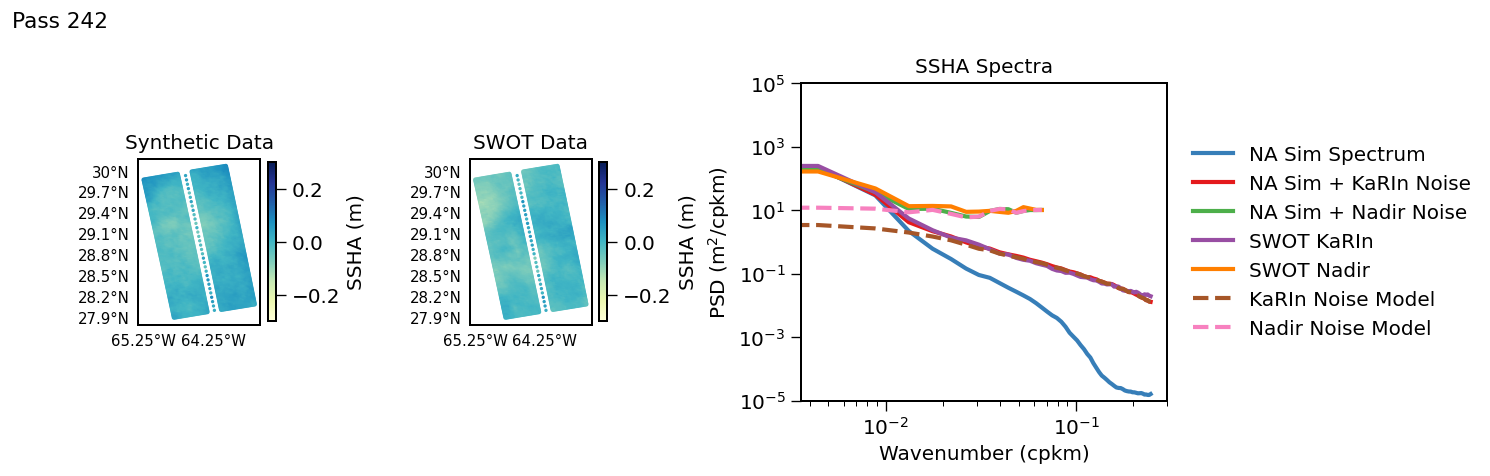

In [15]:
import xarray as xr

# Now we generate our Karin and Nadir noise based on synthetic realizations of the SWOT models 
index = 10

ntime = karin_NA.ssha.shape[0] # simulation times
vmin = -0.3
vmax = 0.3 

cmap = 'YlGnBu'

ssh_noisy = np.empty_like(karin_NA.ssha) # new arrays for synthetic SWOT NA data
ssh_nadir_noisy = np.empty_like(nadir_NA.ssha)

for t in range(0, ntime):

    ssh = karin_NA.ssha[t, :, :] 
    mask = np.isfinite(ssh)      # mask the gap out

    eta_k_reshaped = np.full_like(ssh, np.nan)  
    eta_k_current = etas_k[t, :, :] 

    # Direct assignment of flattened valid data:
    eta_k_reshaped[mask] = eta_k_current.flatten()

    # Add noise to SSH, preserving gaps:
    ssh_noisy[t, :, :] = ssh + eta_k_reshaped

    # --- Nadir ---
    ssh_nadir = nadir_NA.ssha[t, :]
    ssh_nadir_noisy[t] = ssh_nadir + etas_n[t]


kt_NA_coords    = [np.arange(ntime), karin.y_coord, karin.x_coord]
ssh_noisy_xr = xr.DataArray(ssh_noisy, coords = kt_NA_coords, dims = ['sample', 'line', 'pixel'])
spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin.window, 'line', ['sample', 'pixel'])
spec_ssh_noisy = spec_ssh_noisy[int(karin.track_length/2):] # take the half spectrum

nad_noisy_xr   = xr.DataArray(ssh_nadir_noisy, coords = eta_nt_coords, dims = ['sample', 'nadir_line'])
spec_nad_noisy = swot.mean_power_spectrum(nad_noisy_xr, nadir.window, 'nadir_line', ['sample'])
spec_nad_noisy = spec_nad_noisy[int(nadir.track_length/2):]

karin_NA.ssh_noisy = ssh_noisy # save the generated noisy fields to our NA simulation classes 
nadir_NA.ssh_noisy = ssh_nadir_noisy

fig = plt.figure(figsize=(12, 4), dpi=120)
gs = GridSpec(1, 3, width_ratios=[1, 1, 2.4], figure=fig)

# ───── Simulation Map ─────
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
sc0 = ax0.scatter(
    karin.lon[index].flatten(), karin.lat[index].flatten(),
    c=ssh_noisy[index], s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax0.scatter(
    nadir.lon[index], nadir.lat[index], c=ssh_nadir_noisy[index], vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree()
)
ax0.coastlines()
ax0.set_title("Synthetic Data")
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl0.top_labels = gl0.right_labels = False
gl0.xlabel_style = {'size': 9}  # or your preferred size
gl0.ylabel_style = {'size': 9}
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.5, pad=0.05)
cbar0.set_label("SSHA (m)")

# ───── SWOT Map ─────
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
sc1 = ax1.scatter(
    karin.lon[index], karin.lat[index],
    c=karin.ssha[index], s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax1.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=1, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o'
)
ax1.coastlines()
ax1.set_title(f'SWOT Data')
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl1.top_labels = gl1.right_labels = False
gl1.xlabel_style = {'size': 9}  # or your preferred size
gl1.ylabel_style = {'size': 9}
cbar1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.5, pad=0.05)
cbar1.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax2 = fig.add_subplot(gs[0, 2])
ax2.loglog(karin_NA.wavenumbers_cpkm, karin_NA.spec_alongtrack_av, label='NA Sim Spectrum', linewidth=2.5)
ax2.loglog(spec_ssh_noisy.freq_line * 1e3, spec_ssh_noisy, label='NA Sim + KaRIn Noise', linewidth=2.5)
ax2.loglog(k_nadir*1e3, spec_nad_noisy, label='NA Sim + Nadir Noise', linewidth=2.5)

ax2.loglog(karin.wavenumbers_cpkm, karin.spec_alongtrack_av, '-', label='SWOT KaRIn', linewidth=2.5)
ax2.loglog(nadir.wavenumbers_cpkm, nadir.spec_alongtrack_av, '-', label='SWOT Nadir', linewidth=2.5)
ax2.loglog(k_karin * 1e3, spec_eta_k,'--', lw=2.5, label='KaRIn Noise Model')
ax2.loglog(k_nadir * 1e3, spec_eta_n, '--', lw=2.5, label='Nadir Noise Model')

ax2.set_xlabel("Wavenumber (cpkm)")
ax2.set_ylabel("PSD (m$^2$/cpkm)")
ax2.set_ylim(ylims)
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
#ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_title("SSHA Spectra")

plt.suptitle(f"Pass {pass_num:03d}", x=0.0, ha='center', fontsize=13)
plt.tight_layout()
#plt.subplots_adjust(left=0.05, right=0.98, bottom=0.12, top=0.89, wspace=0.15)
plt.savefig('synthetic_swot_data.pdf', bbox_inches='tight')
plt.show()

In [34]:
# test: apply the balanced model fit the NA sim karin
k_karin_NA = (karin_NA.wavenumbers[int(karin_NA.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean_NA = karin_NA.spec_alongtrack_av[int(karin_NA.track_length/2):]

spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin.window, 'line', ['sample', 'pixel'])
spec_ssh_noisy_half = spec_ssh_noisy[int(karin.track_length/2):] # take the half spectrum

# KARIN
poptcwg_karin_NA, pcovcwg_karin_NA = swot.fit_spectrum(karin_NA, spec_ssh_noisy, swot.karin_model)

# plot KARIN
spbalanced = swot.balanced_model(k_karin_NA[1:],*poptcwg_karin_NA[0:3])
spunbalanced = swot.unbalanced_model(k_karin_NA,*poptcwg_karin_NA[3:7])

plt.figure(figsize=(5.5,5), dpi=120)
k_km = k_karin * 1e3 # wavenumbers in km for plotting
plt.loglog(k_km[1:], karin_spec_sample_mean_NA[1:],'o', label = 'Simulation Data')
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced: $A_n$=%5.3f, $\lambda_n$=%5.3f, $S_n$=%5.3f' % (poptcwg_karin_NA[3], 100, poptcwg_karin_NA[5]))
plt.loglog(k_km[1:], spbalanced,label = r'Balanced: $A_b$=%5.3f, $\lambda_b$=%5.3f, $S_b$=%5.3f' % (poptcwg_karin_NA[0], poptcwg_karin_NA[1]*1e-3, poptcwg_karin_NA[2]))
# plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.loglog(k_km[1:], spec_ssh_noisy_half[1:],'-',label = 'NA Sim + SWOT Noise')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
plt.xlim(1e-3, 3e-1)
plt.title(f'Synthetic Karin Data Pass {pass_num:03d}')


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.4018e+03 ± 1.61e+02
lambda balanced :   1.4102e+05 ± 3.81e+03
slope balanced  :   6.4196e+00 ± 2.15e-01
Amp. noise      :   3.5847e+00 ± 6.61e-01
lambda noise    :   1.0000e+05 ± 0.00e+00
slope noise     :   1.5792e+00 ± 7.92e-02


Text(0.5, 1.0, 'Synthetic Karin Data Pass 009')

## 4. Apply extraction to the NA simulation data with synthetic SWOT noise

In [35]:
from scipy.linalg import block_diag

index = 40 # time index to estimate on 

# Parameters from spectral estimation on the synthetic SWOT data
A_b, lam_b, s_param = poptcwg_karin_NA[0], poptcwg_karin_NA[1], poptcwg_karin_NA[2] # balanced params from fit
A_n, s_n, lam_n = poptcwg_karin_NA[3], poptcwg_karin_NA[5], 1e5 # unbalanced params from fit, we fixed lam_k to 100km in unbalanced model above
N_n = poptcwg_nadir[0] # Nadir noise

# balanced covariance functions
S = lambda k: A_b / (1 + (lam_b * k)**s_param)
c = swot.cov(S, 5000000, 10000e3)

# unbalanced covaiance functions
cutoff = 1e3
sigma = 2 * np.pi * cutoff/np.sqrt(2*np.log(2)) 
Sk = lambda k: A_n / (1 + (lam_n * k)**2)**(s_n / 2) * np.exp(-0.5 * ((sigma**2)*(k**2))) # adds guassian taper to smallest scales
nk = swot.cov(Sk, 5000, 10000e3)
sigma = np.sqrt(N_n / (2 * dn))

# Build masks
mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])

# Obs values from our measurement 
h_obs = np.concatenate((
    karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
    nadir_NA.ssh_noisy[index][mask_n]
))

# Build covariance matrix
xkk = karin_NA.x_grid[mask_k].flatten(order="C")
ykk = karin_NA.y_grid[mask_k].flatten(order="C")
xnn = nadir_NA.x_grid.ravel()[mask_n]
ynn = nadir_NA.y_grid.ravel()[mask_n]

xobs = np.concatenate((xkk, xnn))
yobs = np.concatenate((ykk, ynn))

# Build covariance matrix
C_obs = swot.build_covariance_matrix(c, xobs, yobs)

# Build noise matrices
Nk_obs = nk(np.hypot(
    xobs[:len(xkk), None] - xobs[:len(xkk)],
    yobs[:len(xkk), None] - yobs[:len(xkk)]
))

Nn_obs = sigma**2 * np.eye(len(xnn))
N_obs = block_diag(Nk_obs, Nn_obs)

# target grids 
xt, yt, nxt, nyt = swot.make_target_grid(karin_NA, extend = False) # we've flipped xt and yt so the grid align

# compute the covariance first 
R = c(np.hypot(xt[:, None] - xobs, yt[:, None] - yobs))

# Estimate signal
ht_NA_sim = swot.estimate_signal_on_target(c, xt, yt, xobs, yobs, C_obs, N_obs, h_obs)
#ht_NA_sim = swot.estimate_signal_on_target_fast(R, C_obs, N_obs, h_obs)

Variance from spectrum:   0.017731
Variance from covariance: 0.017731
Variance from spectrum:   0.000071
Variance from covariance: 0.000071
Calculating covariance matrices...
Estimating signal on target points...
Signal estimation time: 9.2659 seconds


### Compute the posterior covariances for doing the error checking

In [17]:
import numpy as np
from scipy.linalg import solve

C_target = swot.build_covariance_matrix(c, xt, yt) # Covariance of my target matrix

#  P = C_target - R(C_obs + N_obs)⁻¹ @ R.T
print("Solving linear part")
term = solve(C_obs + N_obs, R.T, assume_a='pos') # assume positive definite 

# 2. Posterior
print("posterior covariance matrix")
P = C_target - R @ term

# 3. Diagonal is posterior variance
posterior_variance = np.diag(P)

# 4. Reshape to target grid
posterior_variance_field = posterior_variance.reshape(nyt, nxt)
print("Done.")

Calculating covariance matrices...
Solving linear part
posterior covariance matrix
Done.


In [18]:
from scipy.linalg import solve, cholesky
import scipy.sparse as sp

def laplacian_operator(ny, nx, dx, dy): # 2nd order acc central diff with 2nd order forward diff at boundaries
    N = ny * nx
    L = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # X
            if i == 0:
                L[k, idx(i, j)]     +=  2 / dx**2
                L[k, idx(i+1, j)]   += -5 / dx**2
                L[k, idx(i+2, j)]   +=  4 / dx**2
                L[k, idx(i+3, j)]   += -1 / dx**2
            elif i == 1 or i == nx - 2:
                L[k, idx(i-1, j)]   +=  1 / dx**2
                L[k, idx(i, j)]     += -2 / dx**2
                L[k, idx(i+1, j)]   +=  1 / dx**2
            elif i == nx - 1:
                L[k, idx(i, j)]     +=  2 / dx**2
                L[k, idx(i-1, j)]   += -5 / dx**2
                L[k, idx(i-2, j)]   +=  4 / dx**2
                L[k, idx(i-3, j)]   += -1 / dx**2
            else:
                L[k, idx(i-1, j)]   +=  1 / dx**2
                L[k, idx(i, j)]     += -2 / dx**2
                L[k, idx(i+1, j)]   +=  1 / dx**2

            # Y 
            if j == 0:
                L[k, idx(i, j)]     +=  2 / dy**2
                L[k, idx(i, j+1)]   += -5 / dy**2
                L[k, idx(i, j+2)]   +=  4 / dy**2
                L[k, idx(i, j+3)]   += -1 / dy**2
            elif j == 1 or j == ny - 2:
                L[k, idx(i, j-1)]   +=  1 / dy**2
                L[k, idx(i, j)]     += -2 / dy**2
                L[k, idx(i, j+1)]   +=  1 / dy**2
            elif j == ny - 1:
                L[k, idx(i, j)]     +=  2 / dy**2
                L[k, idx(i, j-1)]   += -5 / dy**2
                L[k, idx(i, j-2)]   +=  4 / dy**2
                L[k, idx(i, j-3)]   += -1 / dy**2
            else:
                L[k, idx(i, j-1)]   +=  1 / dy**2
                L[k, idx(i, j)]     += -2 / dy**2
                L[k, idx(i, j+1)]   +=  1 / dy**2

    return L.tocsr()
    
def gradient_operator(ny, nx, dx, dy):
    
    N = ny * nx
    Gx = sp.lil_matrix((N, N))
    Gy = sp.lil_matrix((N, N))

    for j in range(ny):
        for i in range(nx):
            idx = j * nx + i
            if 1 <= i < nx - 1:
                Gx[idx, idx - 1] = -0.5 / dx
                Gx[idx, idx + 1] =  0.5 / dx
            if 1 <= j < ny - 1:
                Gy[idx, idx - nx] = -0.5 / dy
                Gy[idx, idx + nx] =  0.5 / dy

    return Gx.tocsr(), Gy.tocsr()

# Build linear operators
Gx, Gy = gradient_operator(nyt, nxt, dx=karin_NA.dx, dy=karin_NA.dy)
Lap = laplacian_operator(nyt, nxt, dx=karin_NA.dx, dy=karin_NA.dy)

# Cholesky decomposition of posterior covariance matrix: P = Lp @ Lp.T
Lp = cholesky(P, lower=True)
print("Cholesky done.")

# Apply operators to Cholesky factor
GLx = Gx @ Lp
print("gradx done")
GLy = Gy @ Lp
print("grady done")
LapL = Lap @ Lp
print("lap done")

# Compute posterior variances (row-wise norms)
var_grad_x = np.sum(GLx**2, axis=1).reshape(nyt, nxt)
var_grad_y = np.sum(GLy**2, axis=1).reshape(nyt, nxt)
var_grad_mag = var_grad_x + var_grad_y
var_laplacian = np.sum(LapL**2, axis=1).reshape(nyt, nxt)

print("Posterior gradient and Laplacian variances computed.")

Cholesky done.
gradx done
grady done
lap done
Posterior gradient and Laplacian variances computed.


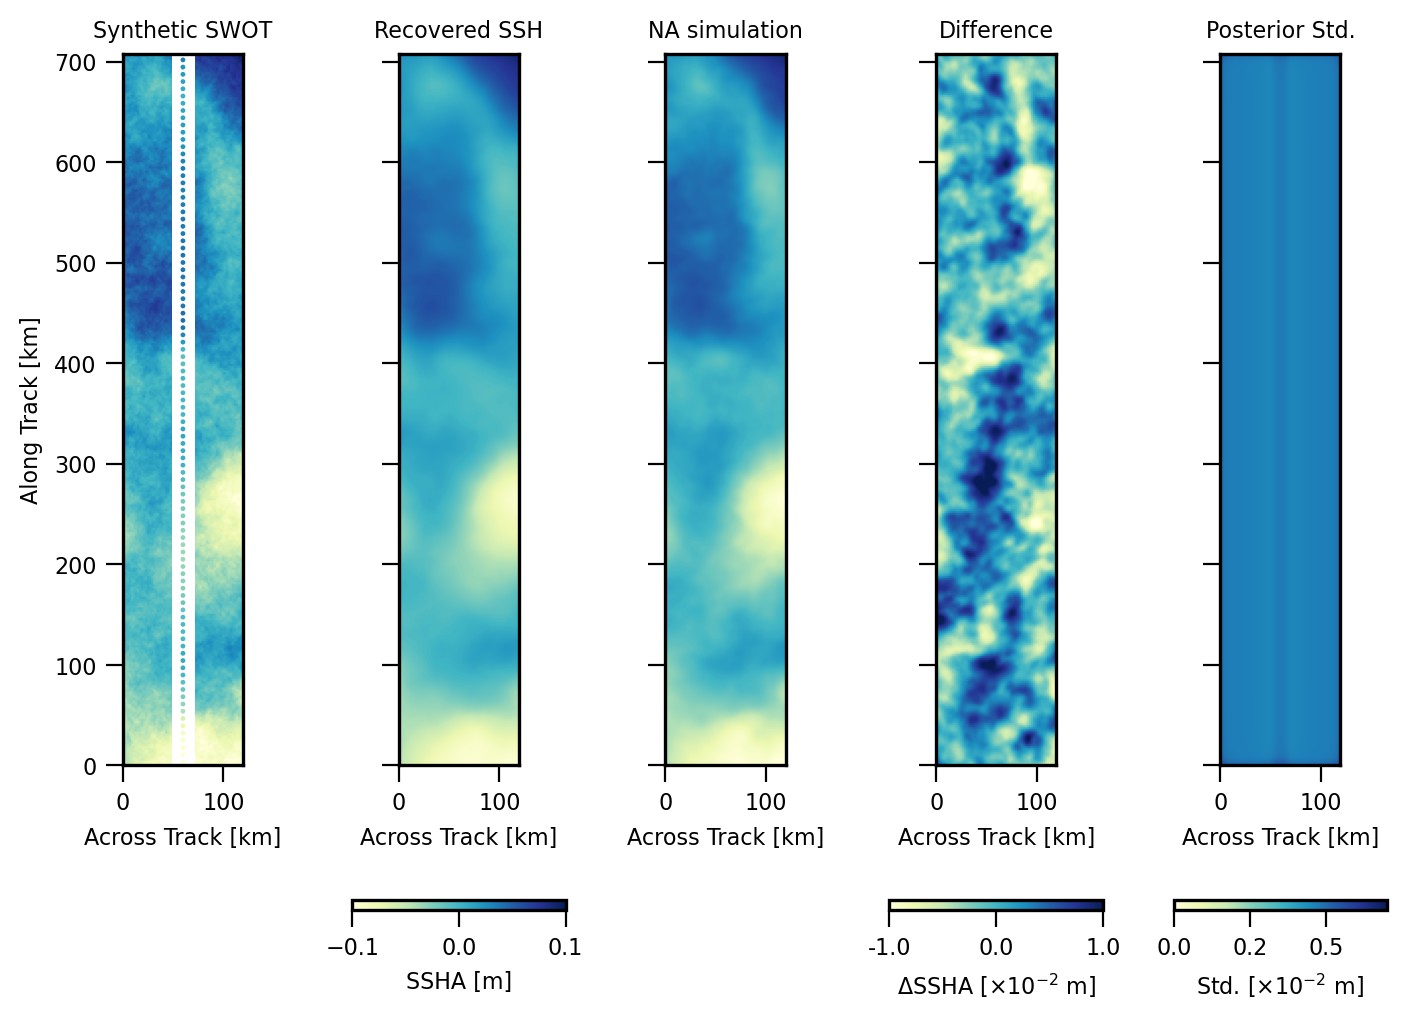

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

cmap = 'YlGnBu'
extent = [0, nxt * karin_NA.dx * 1e-3, 0, nyt * karin_NA.dy * 1e-3]
vmin = -0.1 
vmax = 0.1

# Reshape to 2D (note: imshow expects [rows, cols] = [nyt, nxt])
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssh_orig[index] - np.nanmean(karin_NA.ssh_orig[index])
h_truth_map = h_truth[:, 0:60]
ssha_diff = h_truth_map - ht_map

# Plot
fig, axs = plt.subplots(1, 5, figsize=(7, 5), constrained_layout=True, sharey=True, dpi=200)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(karin_NA.ssh_noisy[index].reshape(nyt, nxt), origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[0].scatter(xnn * 1e-3, ynn * 1e-3, c=nadir_NA.ssha[index][mask_n], s=3,
               cmap=cmap, edgecolor="none", vmin=vmin, vmax=vmax)
axs[0].set_title('Synthetic SWOT', fontsize=8)


# Panel 2: Recovered
im1 = axs[1].imshow(ht_map, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title('Recovered SSH', fontsize=8)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('SSHA [m]', size=8)

# Panel 3: Simulation
im2 = axs[2].imshow(h_truth_map, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title('NA simulation', fontsize=8)

# Panel 4 difference
im3 = axs[3].imshow(ssha_diff, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin = 0.1 * vmin, vmax = 0.1 * vmax)
axs[3].set_title('Difference', fontsize=8)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.07, orientation='horizontal')
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$\Delta$SSHA [$\times 10^{-2}$ m]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e2:.1f}")
cbar.update_ticks()


# Panel 5 posterior variance
im4 = axs[4].imshow(np.sqrt(posterior_variance_field[:, :]), origin='lower', cmap=cmap, aspect='equal', vmin = 0, vmax = 0.7e-2,
                    extent=extent)
axs[4].set_title('Posterior Std.', fontsize=8)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'Std. [$\times 10^{-2}$ m]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e2:.1f}")
cbar.update_ticks()


# Axis labels and ticks
axs[0].set_ylabel('Along Track [km]', fontsize=8)
for ax in axs:
    ax.set_xlabel('Across Track [km]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

plt.show()


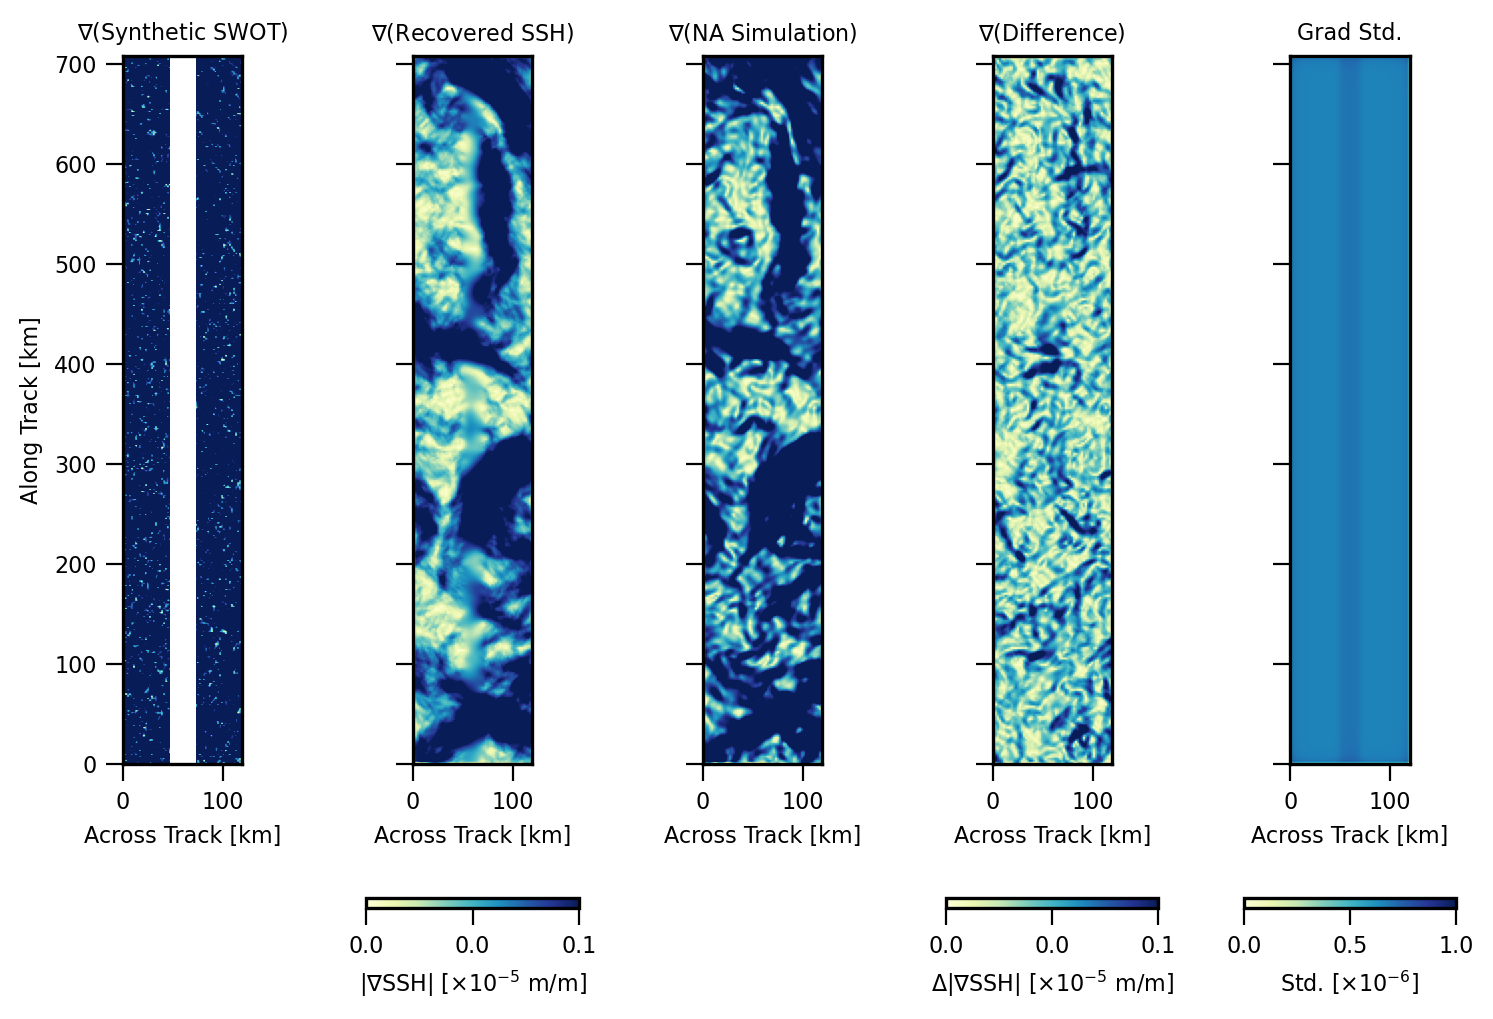

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

cmap = 'YlGnBu'
extent = [0, nxt * karin_NA.dx * 1e-3, 0, nyt * karin_NA.dy * 1e-3]
vmin = 0
vmax = 1e-6  # for gradients

# Reshape to 2D
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssh_orig[index] - np.nanmean(karin_NA.ssh_orig[index])
h_truth_map = h_truth[:, :nxt]

# Gradients
g_obs = swot.compute_gradient(karin_NA.ssh_noisy[index].reshape(nyt, nxt), karin_NA.dx, karin_NA.dy)
g_recon = swot.compute_gradient(ht_map, karin_NA.dx, karin_NA.dy)
g_truth = swot.compute_gradient(h_truth_map, karin_NA.dx, karin_NA.dy)
g_diff = swot.compute_gradient(h_truth_map - ht_map, karin_NA.dx, karin_NA.dy)


# Plot
fig, axs = plt.subplots(1, 5, figsize=(7.5, 5), constrained_layout=True, sharey=True, dpi=200)

# Panel 1: ∇(Synthetic SWOT)
im0 = axs[0].imshow(g_obs, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[0].set_title(r'$\nabla$(Synthetic SWOT)', fontsize=8)

# Panel 2: ∇(Recovered SSH)
im1 = axs[1].imshow(g_recon, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title(r'$\nabla$(Recovered SSH)', fontsize=8)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'$|\nabla \mathrm{SSH}|$ [$\times 10^{-5}$ m/m]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e5:.1f}")
cbar.update_ticks()

# Panel 3: ∇(NA Simulation)
im2 = axs[2].imshow(g_truth, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title(r'$\nabla$(NA Simulation)', fontsize=8)

# Panel 4: ∇(Difference)
im3 = axs[3].imshow(g_diff, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[3].set_title(r'$\nabla$(Difference)', fontsize=8)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'$\Delta|\nabla \mathrm{SSH}|$ [$\times 10^{-5}$ m/m]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e5:.1f}")
cbar.update_ticks()

# Panel 5: Posterior variance
im4 = axs[4].imshow(np.sqrt(var_grad_mag), origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin = 0, vmax = 1e-6)
axs[4].set_title('Grad Std.', fontsize=8)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'Std. [$\times 10^{-6}$]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e6:.1f}")
cbar.update_ticks()

# Axes
axs[0].set_ylabel('Along Track [km]', fontsize=8)
for ax in axs:
    ax.set_xlabel('Across Track [km]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

plt.show()

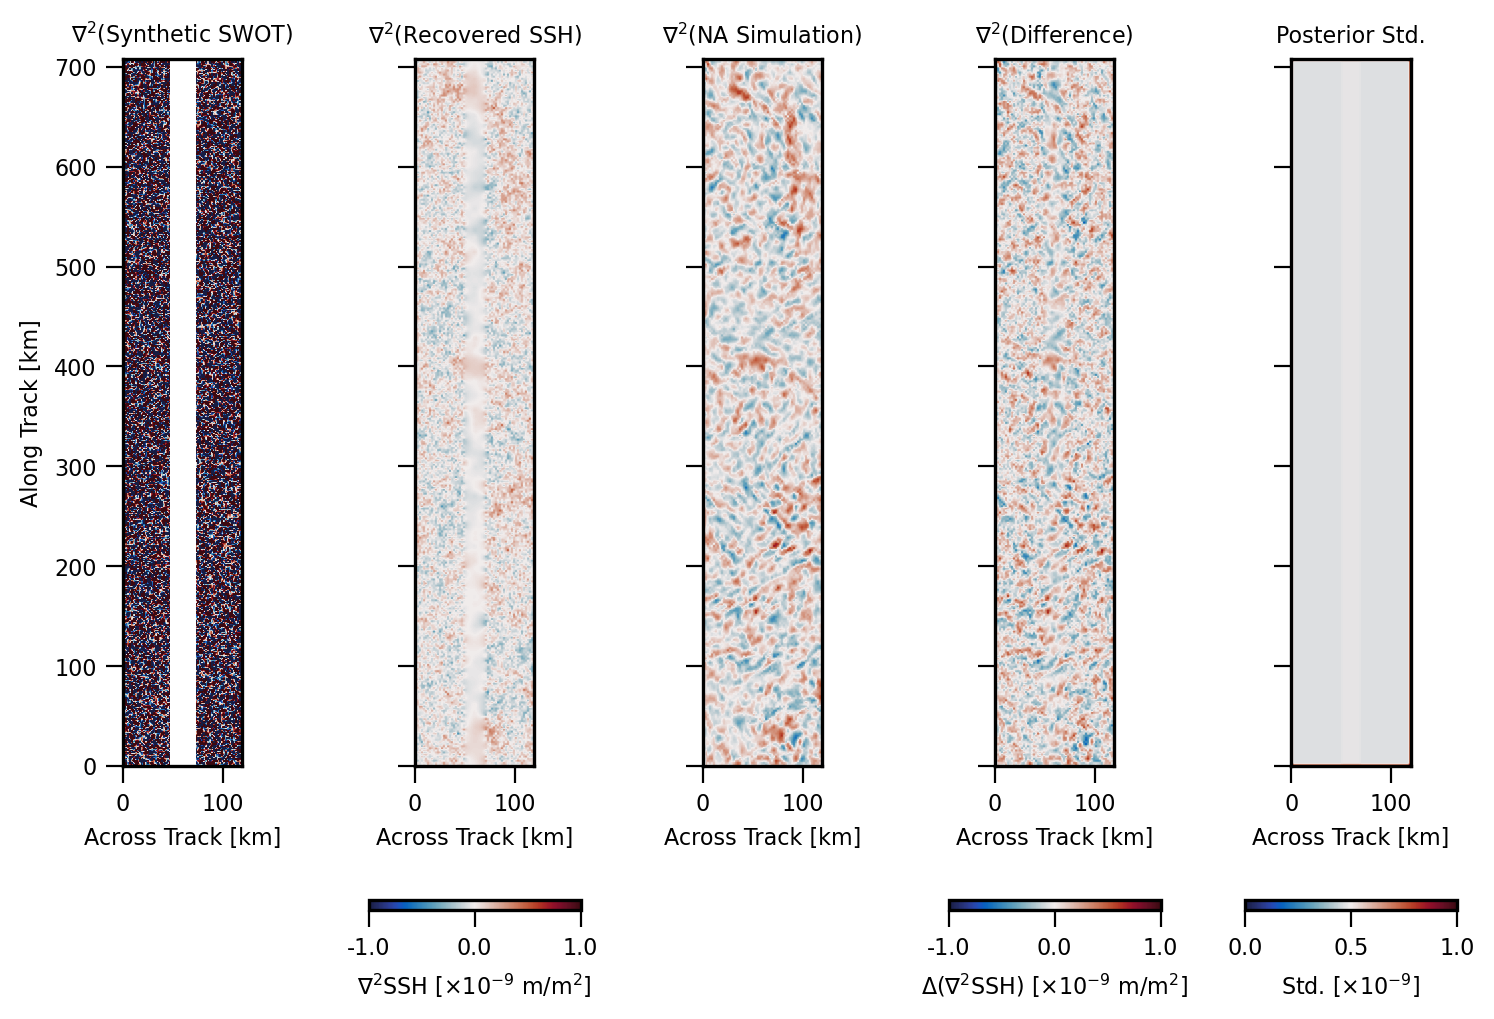

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

cmap = cmocean.cm.balance
extent = [0, nxt * karin_NA.dx * 1e-3, 0, nyt * karin_NA.dy * 1e-3]
vmin = -1e-9
vmax = 1e-9

# Reshape SSH fields to 2D
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssh_orig[index] - np.nanmean(karin_NA.ssh_orig[index])
h_truth_map = h_truth[:, :nxt]

# Compute Laplacians
lap_obs = swot.compute_laplacian(karin_NA.ssh_noisy[index].reshape(nyt, nxt), karin_NA.dx, karin_NA.dy)
lap_recon = swot.compute_laplacian(ht_map, karin_NA.dx, karin_NA.dy)
lap_truth = swot.compute_laplacian(h_truth_map, karin_NA.dx, karin_NA.dy)
lap_diff = swot.compute_laplacian(h_truth_map - ht_map, karin_NA.dx, karin_NA.dy)


# Plot
fig, axs = plt.subplots(1, 5, figsize=(7.5, 5), constrained_layout=True, sharey=True, dpi=200)

# Panel 1: Laplacian of synthetic SWOT
im0 = axs[0].imshow(lap_obs, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[0].set_title(r'$\nabla^2$(Synthetic SWOT)', fontsize=8)

# Panel 2: Laplacian of recovered SSH
im1 = axs[1].imshow(lap_recon, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title(r'$\nabla^2$(Recovered SSH)', fontsize=8)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'$\nabla^2 \mathrm{SSH}$ [$\times 10^{-9}$ m/m$^2$]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e9:.1f}")
cbar.update_ticks()

# Panel 3: Laplacian of simulation
im2 = axs[2].imshow(lap_truth, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title(r'$\nabla^2$(NA Simulation)', fontsize=8)

# Panel 4: Laplacian of difference
im3 = axs[3].imshow(lap_diff, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[3].set_title(r'$\nabla^2$(Difference)', fontsize=8)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'$\Delta(\nabla^2 \mathrm{SSH})$ [$\times 10^{-9}$ m/m$^2$]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e9:.1f}")
cbar.update_ticks()

# Panel 5: Posterior variance
im4 = axs[4].imshow(np.sqrt(var_laplacian[:, :]), origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin = 0, vmax = 1e-9)
axs[4].set_title('Posterior Std.', fontsize=8)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'Std. [$\times 10^{-9}$]', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e9:.1f}")
cbar.update_ticks()

# Axes formatting
axs[0].set_ylabel('Along Track [km]', fontsize=8)
for ax in axs:
    ax.set_xlabel('Across Track [km]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

plt.show()

In [28]:
# Compute the geostrophic vorticity 
cmap = cmocean.cm.balance
extent = [0, nxt * karin_NA.dx * 1e-3, 0, nyt * karin_NA.dy * 1e-3]
vmin = -1
vmax = 1

# Reshape SSH fields to 2D
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssh_orig[index] - np.nanmean(karin_NA.ssh_orig[index])
h_truth_map = h_truth[:, :nxt]

## Vorticity fields
lats = np.linspace(np.nanmin(karin_NA.lat[index]), np.nanmax(karin_NA.lat[index]), nyt)

# Compute geostrophic vorticies 
vort_obs = swot.compute_geostrophic_vorticity_fd(karin_NA.ssh_noisy[index].reshape(nyt, nxt), 2000, 2000, lats)
vort_recon = swot.compute_geostrophic_vorticity_fd(ht_map, 2000, 2000, lats)
vort_truth = swot.compute_geostrophic_vorticity_fd(h_truth_map, 2000, 2000, lats)
vort_diff = vort_truth - vort_recon

omega = 7.2921e-5
f = 2 * omega * np.sin(np.deg2rad(lat))

post_std_zeta = (np.sqrt(var_laplacian) * 9.8) / np.nanmax(f)**2 # rough calc using mean f

# Plot
fig, axs = plt.subplots(1, 5, figsize=(7.5, 5), constrained_layout=True, sharey=True, dpi=200)

# Panel 1: Laplacian of synthetic SWOT
im0 = axs[0].imshow(vort_obs, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[0].set_title(r'Synthetic SWOT $\zeta$', fontsize=8)

# Panel 2: Laplacian of recovered SSH
im1 = axs[1].imshow(vort_recon, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title(r'Recovered $\zeta$', fontsize=8)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'$\zeta / f$', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.update_ticks()

# Panel 3: Laplacian of simulation
im2 = axs[2].imshow(vort_truth, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title(r'NA Simulation $\zeta$', fontsize=8)

# Panel 4: Laplacian of difference
im3 = axs[3].imshow(vort_diff, origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[3].set_title(r'$\zeta$ Difference', fontsize=8)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'$\zeta / f$', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.update_ticks()

# Panel 5: Posterior variance
im4 = axs[4].imshow(post_std_zeta[:, :], origin='lower', cmap=cmap, aspect='equal', extent=extent, vmin = 0, vmax = 1.0)
axs[4].set_title('Posterior Std.', fontsize=8)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.07, orientation='horizontal')
cbar.set_label(r'Std. $\zeta / f$', size=8)
cbar.ax.tick_params(labelsize=8)
cbar.update_ticks()

# Axes formatting
axs[0].set_ylabel('Along Track [km]', fontsize=8)
for ax in axs:
    ax.set_xlabel('Across Track [km]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

plt.show()

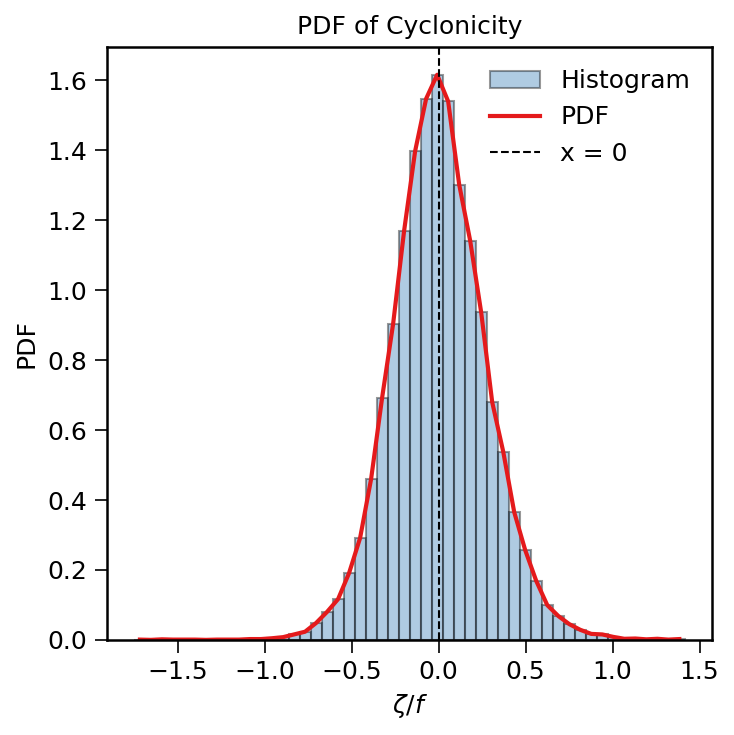

In [33]:
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis
from matplotlib.offsetbox import AnchoredText

# Make a plot of the skewness and kurtosis of the vorticity
vals = vort_truth.ravel()
vals = vals[~np.isnan(vals)]

n_bins = 50
hist, edges = np.histogram(vals, bins=n_bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])


plt.figure(figsize=(5, 5))
plt.hist(vals, bins=n_bins, density=True,
         alpha=0.4, edgecolor='k', label='Histogram')

plt.plot(centers, hist, '-', lw=2, label='PDF')
plt.axvline(0, color='k', linestyle='--', linewidth=1, label='x = 0')


# labels & legend
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis
from matplotlib.offsetbox import AnchoredText

# Make a plot of the skewness and kurtosis of the vorticity
vals = vort_recon.ravel()
vals = vals[~np.isnan(vals)]

n_bins = 50
hist, edges = np.histogram(vals, bins=n_bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])


plt.figure(figsize=(5, 5))
plt.hist(vals, bins=n_bins, density=True,
         alpha=0.4, edgecolor='k', label='Histogram')

plt.plot(centers, hist, '-', lw=2, label='PDF')
plt.axvline(0, color='k', linestyle='--', linewidth=1, label='x = 0')


# labels & legend
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

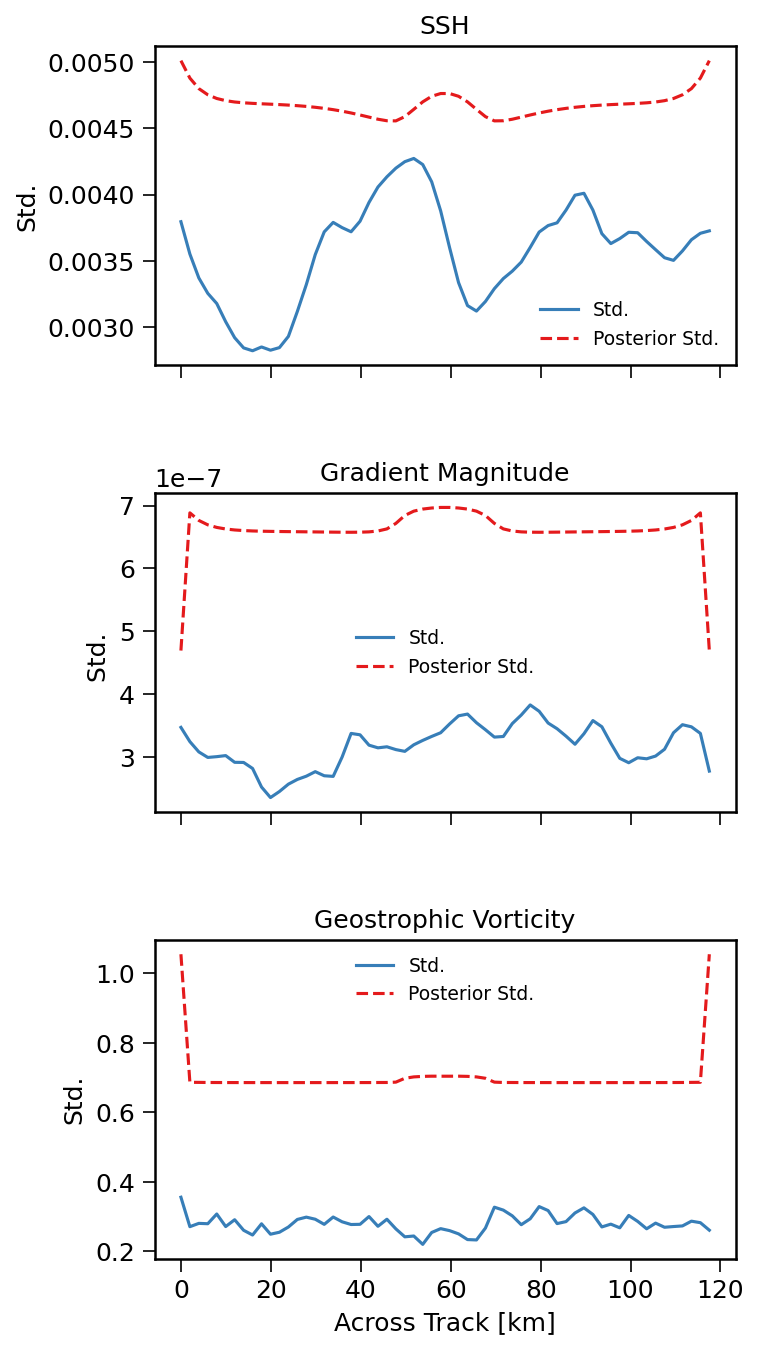

In [29]:
# Across-track coordinate in km
x_km = np.arange(nxt) * karin_NA.dx * 1e-3

# --- 1. SSH ---
ssh_diff_std = np.nanstd(h_truth_map - ht_map, axis=0)
ssh_posterior_std = np.mean(np.sqrt(posterior_variance_field[:, :]), axis=0)

# --- 2. Gradient magnitude ---
grad_diff_std = np.nanstd(g_truth - g_recon, axis=0)
grad_posterior_std = np.mean(np.sqrt(var_grad_mag), axis=0)

# --- 3. Laplacian ---
lap_diff_std = np.nanstd(lap_truth - lap_recon, axis=0)
lap_posterior_std = np.mean(np.sqrt(var_laplacian), axis=0)

# --- 4. Vorticity ---
vort_diff_std = np.nanstd(vort_truth - vort_recon, axis=0)
vort_posterior_std = np.mean(post_std_zeta, axis=0)


fig, axs = plt.subplots(3, 1, figsize=(5, 10.5), dpi=150, sharex=True, sharey=False)

# Increase vertical spacing manually
fig.subplots_adjust(hspace=0.4)

# Panel 1: SSH
axs[0].plot(x_km, ssh_diff_std, label='Std.', linewidth=1.5)
axs[0].plot(x_km, ssh_posterior_std, '--', label='Posterior Std.', linewidth=1.5)
axs[0].set_title('SSH')
axs[0].set_ylabel('Std.')
axs[0].legend(fontsize=9)

# Panel 2: Gradient magnitude
axs[1].plot(x_km, grad_diff_std, label='Std.', linewidth=1.5)
axs[1].plot(x_km, grad_posterior_std, '--', label='Posterior Std.', linewidth=1.5)
axs[1].set_title('Gradient Magnitude')
axs[1].set_ylabel('Std. ')
axs[1].legend(fontsize=9)

# Panel 4: Vorticity
axs[2].plot(x_km, vort_diff_std, label='Std.', linewidth=1.5)
axs[2].plot(x_km, vort_posterior_std, '--', label='Posterior Std.', linewidth=1.5)
axs[2].set_title('Geostrophic Vorticity')
axs[2].set_xlabel('Across Track [km]')
axs[2].set_ylabel(r'Std.')
axs[2].legend(fontsize=9)
#axs[2].set_ylim(0.2, 0.8)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# --- Prepare data ---

# Estimated SSH
ht_map = ht_NA_sim.reshape(nxt, nyt)  # (ny, nx)

# Original simulation (truth)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])  # give ssha of the original simulation

# Noisy observations (masked KaRIn + Nadir)
ssh_k_flat = karin_NA.ssh_noisy[index].flatten(order='C')
mask_k_flat = mask_k.flatten(order='C')
obs_k = ssh_k_flat[mask_k_flat]

# Shared color scale
vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

# Gradient fields
grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

# Vorticity fields
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nxt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), h_truth.shape[0])
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats)

# --- Create figure layout: 4 rows × 2 columns ---
fig, axes = plt.subplots(4, 2, figsize=(15, 13), sharex='col',
                         gridspec_kw={"hspace": 0.4, "wspace": 0.1})

# ===== Row 0: Observations =====
sc0 = axes[0, 0].scatter(
    ykk * 1e-3, xkk * 1e-3, c=obs_k, s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].scatter(
    ynn * 1e-3, xnn * 1e-3, c=nadir_NA.ssh[index][mask_n], s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].set_title("SWOT Noise NA Simulation", fontsize=11)
axes[0, 0].set_ylabel("Across-track (km)")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.7, pad=0.02)

im_obs_truth = axes[0, 1].imshow(
    h_truth.T, origin="lower",
    extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
    cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto'
)
axes[0, 1].set_title("Original NA Simulation")
fig.colorbar(im_obs_truth, ax=axes[0, 1], shrink=0.7, pad=0.02)

# ===== Row 1: SSH maps =====
im0 = axes[1, 0].imshow(ht_map, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Estimated SSH")
axes[1, 0].set_ylabel("Across-track (km)")
fig.colorbar(im0, ax=axes[1, 0], shrink=0.7, pad=0.02)

im1 = axes[1, 1].imshow(h_truth, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.7, pad=0.02)

# ===== Row 2: Gradient maps =====
g0 = axes[2, 0].imshow(grad_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 0].set_title("Gradient (Estimated)")
axes[2, 0].set_ylabel("Across-track (km)")
axes[2, 0].set_xlabel("Along-track (km)")
fig.colorbar(g0, ax=axes[2, 0], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[2, 1].imshow(grad_true, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 1].set_title("Gradient (True)")
axes[2, 1].set_xlabel("Along-track (km)")
fig.colorbar(g1, ax=axes[2, 1], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

# ===== Row 3: Vorticity maps =====
v0 = axes[3, 0].imshow(geo_vort_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 0].set_title("Geostrophic Vorticity (Estimated)")
axes[3, 0].set_ylabel("Across-track (km)")
axes[3, 0].set_xlabel("Along-track (km)")
fig.colorbar(v0, ax=axes[3, 0], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

v1 = axes[3, 1].imshow(geo_vort_true, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 1].set_title("Geostrophic Vorticity (True)")
axes[3, 1].set_xlabel("Along-track (km)")
fig.colorbar(v1, ax=axes[3, 1], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

plt.tight_layout()
plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# --- Reshape and prepare ---
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])

obs_k = karin_NA.ssh_noisy[index][mask_k]
obs_n = nadir_NA.ssh[index][mask_n]

vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nyt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats)

extent = (0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3)  # (x, y) in km

# --- Transposed figure layout: 2 rows × 4 columns ---
fig, axes = plt.subplots(2, 4, figsize=(20, 20), sharey=False, sharex=False,
                         gridspec_kw={"hspace": 0.2, "wspace": 0.2})

# ---- Column 0: Observations ----
sc1 = axes[0, 0].scatter(xkk * 1e-3, ykk * 1e-3, c=ssh_k_obs, cmap=cmocean.cm.balance,
                  s=5, label='KaRIn SSH', edgecolor="none")

# Nadir observations colored by SSH
sc2 = axes[0, 0].scatter(xnn * 1e-3, ynn * 1e-3, c=ssh_n_obs, cmap=cmocean.cm.balance,
                  s=5, label='Nadir SSH', edgecolor="none", marker='x')
axes[0, 0].set_title("SWOT Noisy Obs")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.8, pad=0.02)

im_obs_truth = axes[1, 0].imshow(h_truth, origin="lower", extent=extent,
                                 cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Original Noisy Obs")
fig.colorbar(im_obs_truth, ax=axes[1, 0], shrink=0.8, pad=0.02)

# ---- Column 1: SSH ----
im0 = axes[0, 1].imshow(ht_map, origin="lower", extent=extent,
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[0, 1].set_title("Estimated SSH")
fig.colorbar(im0, ax=axes[0, 1], shrink=0.8, pad=0.02)

im1 = axes[1, 1].imshow(h_truth, origin="lower", extent=extent,
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.8, pad=0.02)

# ---- Column 2: Gradients ----
g0 = axes[0, 2].imshow(grad_est, origin="lower", extent=extent,
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[0, 2].set_title("Gradient (Estimated)")
fig.colorbar(g0, ax=axes[0, 2], shrink=0.8, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[1, 2].imshow(grad_true, origin="lower", extent=extent,
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[1, 2].set_title("Gradient (True)")
fig.colorbar(g1, ax=axes[1, 2], shrink=0.8, pad=0.02, label=r"$\nabla(SSH)$")

# ---- Column 3: Vorticity ----
v0 = axes[0, 3].imshow(geo_vort_est, origin="lower", extent=extent,
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[0, 3].set_title("Vorticity (Estimated)")
fig.colorbar(v0, ax=axes[0, 3], shrink=0.8, pad=0.02, label=r"$\zeta / f$")

v1 = axes[1, 3].imshow(geo_vort_true, origin="lower", extent=extent,
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[1, 3].set_title("Vorticity (True)")
fig.colorbar(v1, ax=axes[1, 3], shrink=0.8, pad=0.02, label=r"$\zeta / f$")

# --- Labels ---
for ax in axes[1, :]:
    ax.set_xlabel("Across-track (km)")
for ax in axes[:, 0]:
    ax.set_ylabel("Along-track (km)")

plt.tight_layout()
plt.savefig("swot_diagnostics_transposed.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import xarray as xr

est_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, ht_map.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, ht_map.shape[1], 1.0) * karin.dx
}

truth_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, h_truth.T.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, h_truth.T.shape[1], 1.0) * karin.dx
}

recovered_xr = xr.DataArray(ht_map[None, :, :], coords=est_coords, dims=['sample', 'pixel', 'line'])
truth_xr     = xr.DataArray(h_truth.T[None, :, :], coords=truth_coords, dims=['sample', 'pixel', 'line'])

# Compute power spectra
spec_est  = swot.mean_power_spectrum(recovered_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])
spec_true = swot.mean_power_spectrum(truth_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])

# Trim to 1-sided spectrum
spec_est = spec_est[int(nx / 2):]
spec_true = spec_true[int(nx / 2):]

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# True and estimated SSH spectra
ax.loglog(k_km[1:], spec_true[1:], lw=2, label='NA SSHA')
ax.loglog(k_km[1:], spec_est[1:], lw=2, label='Estimated SSHA')

# NA sim & noisy spectra
ax.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, lw=2, label='Time Av. NA Sim Spectrum')
# ax.loglog(spec_ssh_noisy.freq_line * 1e3, spec_ssh_noisy, lw=2, label='NA Sim + KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_nad_noisy, lw=2, label='NA Sim + Nadir Noise')

# SWOT observations
# ax.loglog(karin.wavenumbers * 1e3, karin.spec_alongtrack_av, lw=2, label='SWOT KaRIn SSHA')
# ax.loglog(nadir.wavenumbers * 1e3, nadir.spec_alongtrack_av, lw=2, label='SWOT Nadir SSHA')

ax.loglog(k_km[1:], spunbalanced[1:], lw=2, label='Unbalanced Model') # from above model
ax.loglog(k_km[1:], spbalanced, '-', lw=2, label='Balanced Model') # from above model
ax.loglog(k_nadir[1:]*1e3, spnoise_nadir[1:], label = r'Nadir Noise Model')

# # Synthetic noise models
# ax.loglog(k_km, spec_eta_k, ':', lw=2, label='Synthetic KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_eta_n, ':', lw=2, label='Synthetic Nadir Noise')

# Axes formatting
ax.set_xlabel("Wavenumber (cpkm)", fontsize=12)
ax.set_ylabel("PSD (m² / cpkm)", fontsize=12)
ax.set_ylim([1e-6, 1e5])
ax.set_title("Power Spectra Comparison", fontsize=13)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

### Loop over all frames and save the data  

Note here we are saving now a 64 grid rather than the original 60 grid points

We also get some threshold of Nans, like if 30\% or more of the data are NaN then reject it. Just the gap is 0.16 (16%) so if we set threshold to 30% then we are saying the KaRIn data should have no more than ~15% of NaN values

In [ ]:
import pickle
import numpy as np
from joblib import Parallel, delayed
os.environ["NUMEXPR_MAX_THREADS"] = "8" # With 128GB of RAM 4 works

name = "NA_sim"
run_dir = f"./NA_sim_outputs/{name}_P{pass_num:03d}"
os.makedirs(run_dir, exist_ok=True)

print("dirs made")

# ---- Function for processing a single frame ----
def process_frame(index):
    try:
        print(index)
        # Build masks
        mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
        mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])
        
        # Obs values
        h_obs = np.concatenate((
            karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
            nadir_NA.ssh_noisy[index][mask_n]
        ))
        
        xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True)
        
        # Estimate signal
        #ht_NA_sim = swot.estimate_signal_on_target(c, yt, xt, xobs, yobs, C_obs, N_obs, h_obs) # old one
        ht_NA_sim = swot.estimate_signal_on_target_fast(R, C, N, h) # faster with covariance outside the loop
        ht_map = ht_NA_sim.reshape(nyt, nxt)

        lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), nyt)
        gvort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), karin_NA.dx, karin_NA.dy, lats)

        basename = f"P{pass_num:03d}_C{shared_cycles[index]:03d}_{index:03d}"
        filename_SSH = os.path.join(run_dir, f"{basename}_SSH.npy")
        filename_gvort = os.path.join(run_dir, f"{basename}_gvort.npy")
        np.save(filename_SSH, ht_map)
        np.save(filename_gvort, gvort)
        print(f"Frame {index:03d} → saved `{filename_SSH}`")
        
        return filename_SSH
    except Exception as e:
        print(f"Skipping Frame: {index:03d} could not be processed: {e}")
        return None

#process_frame(1)

# ---- Save the karin and nadir classes ----
with open(os.path.join(run_dir, f'karin_class_P{pass_num:03d}.pkl'), 'wb') as f:
    pickle.dump(karin_NA, f)
with open(os.path.join(run_dir, f'nadir_class_P{pass_num:03d}.pkl'), 'wb') as f:
    pickle.dump(nadir_NA, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")

# ---- Run in parallel ----
n_frames = karin_NA.ssha.shape[0]
print(n_frames)
results = Parallel(n_jobs=2, backend='loky')(
    delayed(process_frame)(idx) for idx in range(n_frames)
)


In [ ]:
# extra save Pickle files

with open(os.path.join(run_dir, f'karin_class_SWOT.pkl'), 'wb') as f:
    pickle.dump(karin_NA, f)
with open(os.path.join(run_dir, f'nadir_class_SWOT.pkl'), 'wb') as f:
    pickle.dump(nadir_NA, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")